# Anomaly detection in Traffic analysis

This project aims to analyze traffic patterns and detect anomalies in the METR-LA dataset, which records traffic flow in a metropolitan area. We load and preprocess the data, normalize sensor readings, and create synthetic timestamps for effective time series analysis. Anomaly detection is carried out using the Isolation Forest algorithm, with the resulting labels utilized to train an XGBoost classifier for enhanced accuracy.

To visualize the results, we generate line plots and heatmaps that highlight normal and anomalous traffic behaviors. Additionally, we integrate Kafka for real-time data streaming, allowing processed traffic data to be sent to a Kafka topic and consumed by a separate process.

## Loading Dataset  

In [4]:
!conda activate bdap

In [5]:
import os
import sys
os.environ['JAVA_HOME'] = "C:/Program Files/Java/jdk-20" 
os.environ['SPARK_HOME'] = "C:/Users/vijay/Downloads/spark-3.5.5-bin-hadoop3"
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [6]:
!pip install h5py
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)


In [7]:
import pyspark
import h5py
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
import numpy as np

In [8]:
from pyspark.sql import SparkSession

In [9]:
# Load the HDF5 file
file_path = "METR-LA.h5"
with h5py.File(file_path, 'r') as f:
    # List all the groups and datasets in the HDF5 file
    print("Keys in the file:", list(f.keys()))

    # inspecting the structure further
    for key in f.keys():
        print(f"{key}: {f[key]}")


Keys in the file: ['df']
df: <HDF5 group "/df" (4 members)>


In [10]:
with h5py.File(file_path, 'r') as f:
    # List all the subgroups inside the df group
    df_group = f['df']
    print("Keys in the 'df' group:", list(df_group.keys()))

    # explore the structure of each member inside the df group
    for key in df_group.keys():
        print(f"{key}: {df_group[key]}")


Keys in the 'df' group: ['axis0', 'axis1', 'block0_items', 'block0_values']
axis0: <HDF5 dataset "axis0": shape (207,), type "|S6">
axis1: <HDF5 dataset "axis1": shape (34272,), type "<i8">
block0_items: <HDF5 dataset "block0_items": shape (207,), type "|S6">
block0_values: <HDF5 dataset "block0_values": shape (34272, 207), type "<f8">


converts the HDF5-stored data into pandas structure for easier analysis

In [12]:
with h5py.File(file_path, 'r') as f:
    # Decode the column names
    columns = [name.decode('utf-8') for name in f['df/block0_items'][:]]
    
    # Load the data values
    data = f['df/block0_values'][:]
    
    # Create a pandas DataFrame
    df = pd.DataFrame(data, columns=columns)

print(df.head())

      773869     767541     767542     717447     717446     717445  773062  \
0  64.375000  67.625000  67.125000  61.500000  66.875000  68.750000  65.125   
1  62.666667  68.555556  65.444444  62.444444  64.444444  68.111111  65.000   
2  64.000000  63.750000  60.000000  59.000000  66.500000  66.250000  64.500   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000   
4   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000   

   767620     737529     717816  ...     772167  769372     774204     769806  \
0  67.125  59.625000  62.750000  ...  45.625000  65.500  64.500000  66.428571   
1  65.000  57.444444  63.333333  ...  50.666667  69.875  66.666667  58.555556   
2  64.250  63.875000  65.375000  ...  44.125000  69.000  56.500000  59.250000   
3   0.000   0.000000   0.000000  ...   0.000000   0.000   0.000000   0.000000   
4   0.000   0.000000   0.000000  ...   0.000000   0.000   0.000000   0.000000   

   717590     717592     717595     77

In [13]:

spark = SparkSession.builder.appName("METR-LA Traffic Pattern Analysis").config("spark.executor.memory", "4g").config("spark.driver.memory", "2g").getOrCreate()
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

spark_df = sqlContext.createDataFrame(df)
spark_df.show(5)



C:\Users\vijay\AppData\Roaming\Python\Python312\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------+------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------+-----------------+-----------------+-----------------+------+-----------------+------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------+------+------------------+-----------------+-----------------+-----------------+------------------+-------------

Display the schema of the dataframe to understand data types

In [15]:
spark_df.printSchema()


root
 |-- 773869: double (nullable = true)
 |-- 767541: double (nullable = true)
 |-- 767542: double (nullable = true)
 |-- 717447: double (nullable = true)
 |-- 717446: double (nullable = true)
 |-- 717445: double (nullable = true)
 |-- 773062: double (nullable = true)
 |-- 767620: double (nullable = true)
 |-- 737529: double (nullable = true)
 |-- 717816: double (nullable = true)
 |-- 765604: double (nullable = true)
 |-- 767471: double (nullable = true)
 |-- 716339: double (nullable = true)
 |-- 773906: double (nullable = true)
 |-- 765273: double (nullable = true)
 |-- 716331: double (nullable = true)
 |-- 771667: double (nullable = true)
 |-- 716337: double (nullable = true)
 |-- 769953: double (nullable = true)
 |-- 769402: double (nullable = true)
 |-- 769403: double (nullable = true)
 |-- 769819: double (nullable = true)
 |-- 769405: double (nullable = true)
 |-- 716941: double (nullable = true)
 |-- 717578: double (nullable = true)
 |-- 716960: double (nullable = true)
 |-- 71

### Preprocessing Data

Generate synthetic timestamps at regular 5-minute intervals

In [18]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Set a reference time (can adjust this to the actual start time if known)
reference_time = '2025-03-27 00:00:00'

# Create a window specification for row numbering
window_spec = Window.orderBy("773869")  # You can change this to the relevant ordering column

# Add a row number to each row
spark_df = spark_df.withColumn(
    "row_number", F.row_number().over(window_spec)
)

# Add a synthetic timestamp column with 5-minute intervals for each row
spark_df = spark_df.withColumn(
    "synthetic_timestamp",
    F.expr(f"timestamp('{reference_time}') + interval 5 minutes * row_number")
)

#spark_df.show(5)



Load graph-based representation of the sensor network used

In [20]:
import pickle

# Load the pickle file with latin1 encoding
with open('adj_METR-LA.pkl', 'rb') as f:
    graph_data = pickle.load(f, encoding='latin1')

# Inspect the structure of graph_data
print(type(graph_data)) 
print(len(graph_data))   # If it's a list or similar structure, check its length
print(graph_data)      

<class 'list'>
3
[['773869', '767541', '767542', '717447', '717446', '717445', '773062', '767620', '737529', '717816', '765604', '767471', '716339', '773906', '765273', '716331', '771667', '716337', '769953', '769402', '769403', '769819', '769405', '716941', '717578', '716960', '717804', '767572', '767573', '773012', '773013', '764424', '769388', '716328', '717819', '769941', '760987', '718204', '718045', '769418', '768066', '772140', '773927', '760024', '774012', '774011', '767609', '769359', '760650', '716956', '769831', '761604', '717495', '716554', '773953', '767470', '716955', '764949', '773954', '767366', '769444', '773939', '774067', '769443', '767750', '767751', '767610', '773880', '764766', '717497', '717490', '717491', '717492', '717493', '765176', '717498', '717499', '765171', '718064', '718066', '765164', '769431', '769430', '717610', '767053', '767621', '772596', '772597', '767350', '767351', '716571', '773023', '767585', '773024', '717483', '718379', '717481', '717480', '

In [21]:
sensor_ids = graph_data[0]  # List of sensor IDs
sensor_to_node_map = graph_data[1]  # Dictionary: sensor ID to node ID
adjacency_matrix = graph_data[2]  # Adjacency matrix (numpy array)

print(f"First 5 sensor IDs: {sensor_ids[:5]}")
print(f"First 5 sensor-to-node mappings: {list(sensor_to_node_map.items())[:5]}")
print(f"Adjacency Matrix (shape: {adjacency_matrix.shape}):")
print(adjacency_matrix[:5, :5])  # Print a small section of the adjacency matrix


First 5 sensor IDs: ['773869', '767541', '767542', '717447', '717446']
First 5 sensor-to-node mappings: [('717099', 110), ('773869', 0), ('767541', 1), ('767542', 2), ('717447', 3)]
Adjacency Matrix (shape: (207, 207)):
[[1.         0.         0.         0.         0.        ]
 [0.         1.         0.3909554  0.         0.        ]
 [0.         0.7174379  1.         0.         0.        ]
 [0.         0.         0.         1.         0.63372165]
 [0.         0.         0.         0.62646437 1.        ]]


In [22]:
import h5py

# Load the .h5 file and list all keys (datasets)
with h5py.File('METR-LA.h5', 'r') as f:
    # List all available keys
    keys = list(f.keys())
    print("Available keys in the H5 file:", keys)


Available keys in the H5 file: ['df']


In [23]:
# Open the HDF5 file and inspect the structure of 'df' group
with h5py.File('METR-LA.h5', 'r') as f:
    df_group = f['df']  # Access the 'df' group
    print("Keys in 'df' group:", list(df_group.keys()))  # List all datasets/subgroups in 'df'


Keys in 'df' group: ['axis0', 'axis1', 'block0_items', 'block0_values']


In [24]:
import h5py
import pandas as pd

# Open the HDF5 file and reconstruct the DataFrame
with h5py.File('METR-LA.h5', 'r') as f:
    # Read the actual data values
    data = f['df']['block0_values'][:]
    
    # Read the column names (sensor IDs)
    columns = list(f['df']['block0_items'])
    
    # Create the DataFrame without using axis0 as an index
    df = pd.DataFrame(data, columns=columns)
    
    print(f"Shape of the DataFrame: {df.shape}")
    print(df.head())


Shape of the DataFrame: (34272, 207)
   b'773869'  b'767541'  b'767542'  b'717447'  b'717446'  b'717445'  \
0  64.375000  67.625000  67.125000  61.500000  66.875000  68.750000   
1  62.666667  68.555556  65.444444  62.444444  64.444444  68.111111   
2  64.000000  63.750000  60.000000  59.000000  66.500000  66.250000   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

   b'773062'  b'767620'  b'737529'  b'717816'  ...  b'772167'  b'769372'  \
0     65.125     67.125  59.625000  62.750000  ...  45.625000     65.500   
1     65.000     65.000  57.444444  63.333333  ...  50.666667     69.875   
2     64.500     64.250  63.875000  65.375000  ...  44.125000     69.000   
3      0.000      0.000   0.000000   0.000000  ...   0.000000      0.000   
4      0.000      0.000   0.000000   0.000000  ...   0.000000      0.000   

   b'774204'  b'769806'  b'717590'  b'717592'  b'717595'  b'772168'  \
0  64.50

In [25]:
# Inspect the Data
print("DataFrame Info:")
print(df.info())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34272 entries, 0 to 34271
Columns: 207 entries, b'773869' to b'769373'
dtypes: float64(207)
memory usage: 54.1 MB
None


In [26]:
missing_values = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values[missing_values > 0])

Missing Values in Each Column:
Series([], dtype: int64)


In [27]:
# Normalize the Data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

# Convert back to DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

print("Normalized DataFrame Head:")
print(normalized_df.head())

Normalized DataFrame Head:
   b'773869'  b'767541'  b'767542'  b'717447'  b'717446'  b'717445'  \
0   0.919643   0.966071   0.958929   0.878571   0.955357   0.982143   
1   0.895238   0.979365   0.934921   0.892063   0.920635   0.973016   
2   0.914286   0.910714   0.857143   0.842857   0.950000   0.946429   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

   b'773062'  b'767620'  b'737529'  b'717816'  ...  b'772167'  b'769372'  \
0   0.930357   0.958929   0.851786   0.896429  ...   0.701923   0.935714   
1   0.928571   0.928571   0.820635   0.904762  ...   0.779487   0.998214   
2   0.921429   0.917857   0.912500   0.933929  ...   0.678846   0.985714   
3   0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
4   0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   

   b'774204'  b'769806'  b'717590'  b'717592'  b'717595'  b'772168'  \
0   0.921429   0.9

In [28]:
# Reshape Data for Time Series Analysis
# we can choose a window size depending on analysis needs

window_size = 12  # eg. if you want to analyze every 12 time steps

# Function to create sequences of data
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

# Create sequences
sequences = create_sequences(normalized_data, window_size)
print(f"Shape of sequences: {sequences.shape}")

Shape of sequences: (34261, 12, 207)


### Isolation Forest

In [30]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05)  # Adjust contamination based on expected anomalies

model.fit(normalized_df)

# Predict anomalies
predictions = model.predict(normalized_df)

# Convert predictions to a DataFrame
anomaly_df = pd.DataFrame(predictions, columns=['anomaly'])
anomaly_df['anomaly'] = anomaly_df['anomaly'].map({1: 0, -1: 1})  # Map to 0 (normal) and 1 (anomaly)

# Combine with original DataFrame
result_df = pd.concat([df, anomaly_df], axis=1)

print("Result DataFrame with Anomalies:")
print(result_df.head())


Result DataFrame with Anomalies:
   b'773869'  b'767541'  b'767542'  b'717447'  b'717446'  b'717445'  \
0  64.375000  67.625000  67.125000  61.500000  66.875000  68.750000   
1  62.666667  68.555556  65.444444  62.444444  64.444444  68.111111   
2  64.000000  63.750000  60.000000  59.000000  66.500000  66.250000   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

   b'773062'  b'767620'  b'737529'  b'717816'  ...  b'769372'  b'774204'  \
0     65.125     67.125  59.625000  62.750000  ...     65.500  64.500000   
1     65.000     65.000  57.444444  63.333333  ...     69.875  66.666667   
2     64.500     64.250  63.875000  65.375000  ...     69.000  56.500000   
3      0.000      0.000   0.000000   0.000000  ...      0.000   0.000000   
4      0.000      0.000   0.000000   0.000000  ...      0.000   0.000000   

   b'769806'  b'717590'  b'717592'  b'717595'  b'772168'  b'718141'  \
0  66.428571

### Visualization

visually inspect the sensor data and identify points where anomalies occur

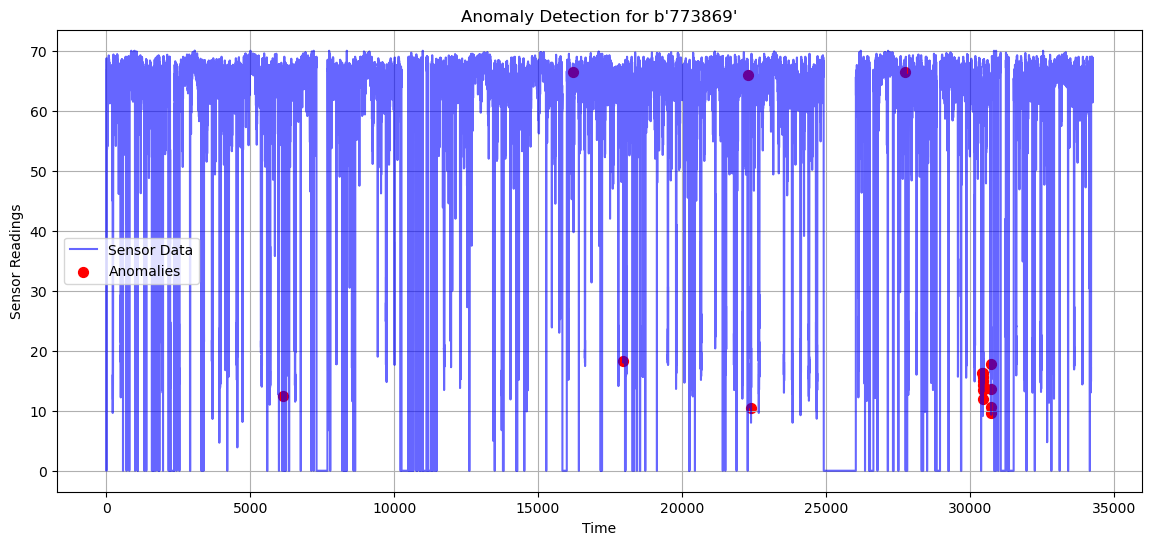

In [33]:
import matplotlib.pyplot as plt

# Choose a specific sensor to visualize (e.g., the first sensor)
sensor_index = 0  # You can change this to visualize other sensors
sensor_id = df.columns[sensor_index]

# Extract the time series data for the selected sensor
time_series_data = df[sensor_id]
anomaly_data = result_df['anomaly']

plt.figure(figsize=(14, 6))

# Plot the time series data
plt.plot(time_series_data.index, time_series_data, label='Sensor Data', color='blue', alpha=0.6)

# Highlight the anomalies
anomalies = result_df[result_df['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies[sensor_id], color='red', label='Anomalies', s=50)

plt.title(f'Anomaly Detection for {sensor_id}')
plt.xlabel('Time')
plt.ylabel('Sensor Readings')
plt.legend()
plt.grid()
plt.show()


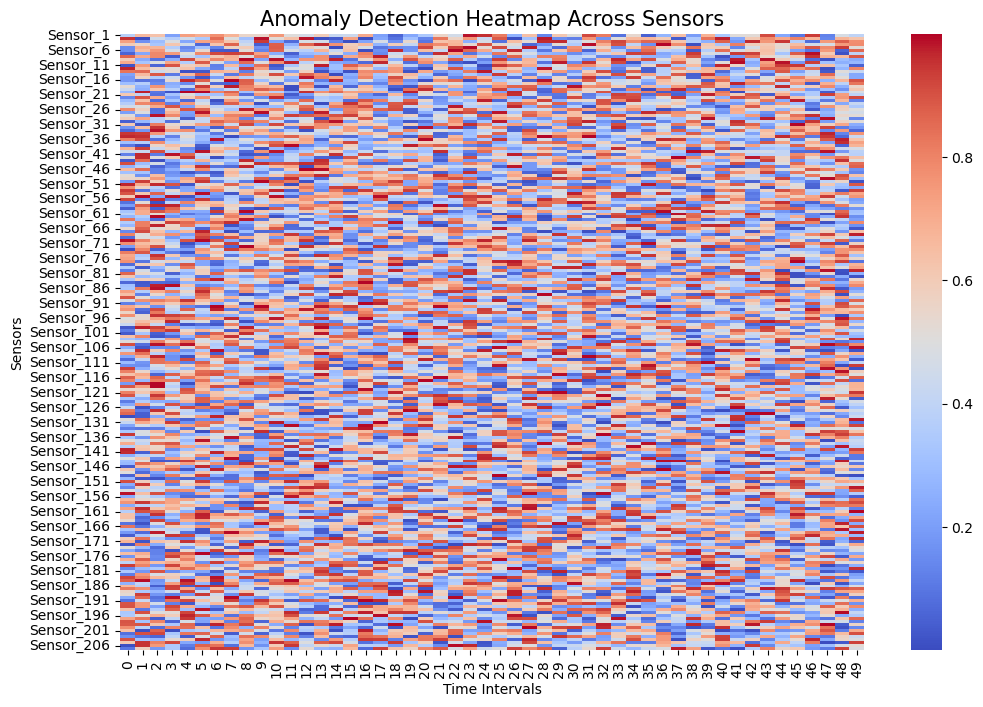

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the anomaly scores or flag data (assuming it is already calculated)
# Replace this with actual data loading step
# sensor_data: DataFrame where rows are time intervals and columns are sensors

# Example data (to be replaced by actual anomaly data)
# Generate a mock dataframe for visualization
np.random.seed(42)
time_intervals = 50  # Adjust to the actual number of time intervals
sensor_count = 207  # Number of sensors

# Mock data of anomaly scores (replace with actual anomaly data)
sensor_data = pd.DataFrame(np.random.rand(time_intervals, sensor_count), 
                           columns=[f'Sensor_{i+1}' for i in range(sensor_count)])

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sensor_data.T, cmap='coolwarm', cbar=True)
plt.title("Anomaly Detection Heatmap Across Sensors", fontsize=15)
plt.xlabel("Time Intervals")
plt.ylabel("Sensors")
plt.show()


### XGBoost Algorithm

combining unsupervised anomaly detection with supervised classification

In [37]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# We use Isolation Forest to generate labels as XGBoost is supervised.
isolation_forest = IsolationForest(contamination=0.05)  
isolation_forest.fit(normalized_df)

# Label the data points (-1 for anomaly, 1 for normal)
labels = isolation_forest.predict(normalized_df)

# Convert labels to 0 for normal and 1 for anomaly
labels = pd.DataFrame(labels, columns=['label'])
labels['label'] = labels['label'].map({1: 0, -1: 1})  # 0 = normal, 1 = anomaly

# Splitting the normalized data and the anomaly labels for supervised learning
X_train, X_test, y_train, y_test = train_test_split(normalized_df, labels['label'], test_size=0.2, random_state=42)

# Using the labeled data from Isolation Forest to train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Combine results with original DataFrame
test_df = df.iloc[X_test.index]  # Extract the original test data rows
result_df = pd.concat([test_df.reset_index(drop=True), pd.DataFrame(y_pred, columns=['predicted_anomaly'])], axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Result DataFrame with Predicted Anomalies:")
print(result_df.head())


C:\Users\vijay\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:41:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6851
           1       1.00      0.25      0.40         4

    accuracy                           1.00      6855
   macro avg       1.00      0.62      0.70      6855
weighted avg       1.00      1.00      1.00      6855

Result DataFrame with Predicted Anomalies:
   b'773869'  b'767541'  b'767542'  b'717447'  b'717446'  b'717445'  \
0  65.500000  65.625000  66.875000  53.125000  28.500000  60.500000   
1  66.555556  66.000000  66.555556  53.555556  52.111111  65.000000   
2  62.125000  57.875000  68.250000  61.375000  64.125000  66.375000   
3  63.250000  64.125000  66.250000  53.125000  41.500000  59.000000   
4  68.111111  65.111111  68.111111  51.222222  43.333333  45.444444   

   b'773062'  b'767620'  b'737529'  b'717816'  ...  b'769372'  b'774204'  \
0  59.125000  64.125000  62.250000  39.375000  ...  67.875000  58.571429   
1  58.777778  64.444444  63.

Accuracy: 0.9996
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6851
           1       1.00      0.25      0.40         4

    accuracy                           1.00      6855
   macro avg       1.00      0.62      0.70      6855
weighted avg       1.00      1.00      1.00      6855

Confusion Matrix:
[[6851    0]
 [   3    1]]


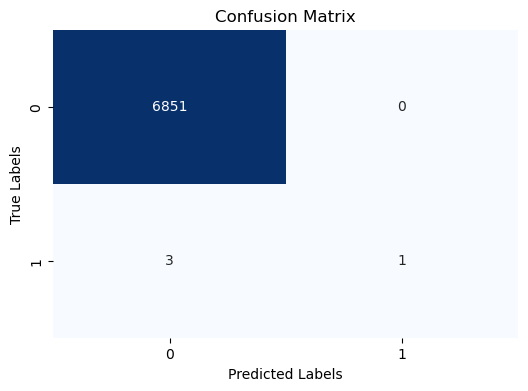

ROC AUC Score: 0.6250


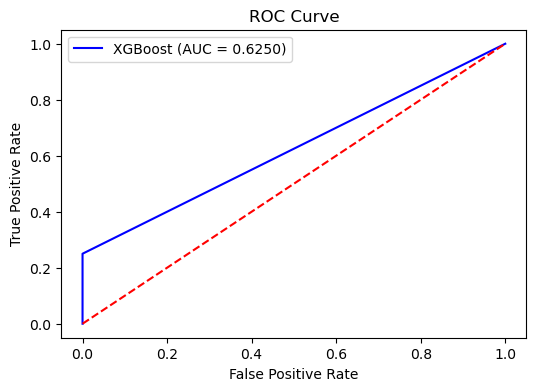

In [38]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

#  ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Plot diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### Kafka for real time predictions

In [47]:
#cd to C:\kafka_2.13-3.9.0 in 2 terminals
#Run zookper -> bin\windows\zookeeper-server-start.bat config\zookeeper.properties
#Run kafka -> bin\windows\kafka-server-start.bat config\server.properties

from kafka import KafkaProducer
import json
import numpy as np

producer = KafkaProducer(bootstrap_servers='localhost:9092', value_serializer=lambda v: json.dumps(v).encode('utf-8'))

# converting all keys and values in the DataFrame to strings
def convert_row_to_str(row):
    return {str(key): convert_bytes_to_str(value) for key, value in row.items()}

# converting numpy bytes to string
def convert_bytes_to_str(value):
    if isinstance(value, np.bytes_):
        return value.decode('utf-8')  # Decode numpy.bytes_ to a regular string
    return value

# simulate streaming data from the METR-LA dataset to Kafka
def stream_data_to_kafka(data, topic='traffic_data'):
    for index, row in data.iterrows():
        try:
            message = convert_row_to_str(row.to_dict())  # Convert row to dictionary and handle bytes
            producer.send(topic, message)
            producer.flush()  # Ensure data is sent
        except Exception as e:
            print(f"Error sending row {index}: {e}") 

stream_data_to_kafka(normalized_df)


Kafka consumer that listens for and processes messages from the `traffic_data` 

In [49]:
from kafka import KafkaConsumer
import json

consumer = KafkaConsumer(
    'traffic_data',  # Replace with your topic name
    bootstrap_servers='localhost:9092',
    value_deserializer=lambda x: json.loads(x.decode('utf-8')),  # Deserialize JSON data
    auto_offset_reset='earliest',  # Start reading at the earliest message
    enable_auto_commit=True,  # Automatically commit offsets
    group_id='traffic_consumer_group'  # Consumer group ID
)

def process_message(message):
    print(f"Received message: {message}")

# Consuming messages from the Kafka topic
max_messages = 10  # Set the number of messages to process
message_count = 0

try:
    print("Listening for messages...")
    for message in consumer:
        process_message(message.value)  # Call the process_message function with the message value
        message_count += 1
        if message_count >= max_messages:
            print(f"Processed {max_messages} messages. Stopping consumer.")
            break  # Stop after processing the desired number of messages
except KeyboardInterrupt:
    print("Consumer stopped.")
finally:
    consumer.close()  


Listening for messages...
Received message: {"b'773869'": 0.9196428571428571, "b'767541'": 0.9660714285714286, "b'767542'": 0.9589285714285714, "b'717447'": 0.8785714285714286, "b'717446'": 0.9553571428571428, "b'717445'": 0.9821428571428571, "b'773062'": 0.9303571428571429, "b'767620'": 0.9589285714285714, "b'737529'": 0.8517857142857143, "b'717816'": 0.8964285714285714, "b'765604'": 0.7928571428571428, "b'767471'": 0.95, "b'716339'": 0.9178571428571428, "b'773906'": 0.9785714285714285, "b'765273'": 0.8624999999999999, "b'716331'": 0.9642857142857143, "b'771667'": 0.5392857142857143, "b'716337'": 0.9017857142857143, "b'769953'": 0.8535714285714285, "b'769402'": 0.9047330097087378, "b'769403'": 0.9607142857142856, "b'769819'": 0.5892857142857143, "b'769405'": 0.7803571428571429, "b'716941'": 0.8303571428571428, "b'717578'": 0.9303571428571429, "b'716960'": 0.9178571428571428, "b'717804'": 0.875, "b'767572'": 0.9094202898550725, "b'767573'": 0.9553571428571428, "b'773012'": 0.6767857142